<a href="https://colab.research.google.com/github/cemreefe/cmpe493-project/blob/main/493_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install xmltodict

import os
import tarfile
import pandas as pd
import xmltodict
import json
import io   
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
def read_file(path):
  with open(path, 'r') as f:
    return f.read()

In [4]:
if not os.path.exists('drive/MyDrive/CMPE/CMPE493'):
  os.makedirs('drive/MyDrive/CMPE/CMPE493')

In [5]:
if not os.path.exists('drive/MyDrive/CMPE/CMPE493/topics-rnd5.xml'):
  !curl https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml --output drive/MyDrive/CMPE/CMPE493/topics-rnd5.xml

if not os.path.exists('drive/MyDrive/CMPE/CMPE493/qrels-covid_d5_j0.5-5.txt'):
  !curl https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt --output drive/MyDrive/CMPE/CMPE493/qrels-covid_d5_j0.5-5.txt

if not os.path.exists('drive/MyDrive/CMPE/CMPE493/cord-19_2020-07-16.tar.gz'):
  !curl https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases/cord-19_2020-07-16.tar.gz --output drive/MyDrive/CMPE/CMPE493/cord-19_2020-07-16.tar.gz

In [6]:
if not os.path.exists('2020-07-16'):
  tar = tarfile.open('drive/MyDrive/CMPE/CMPE493/cord-19_2020-07-16.tar.gz', "r:gz")
  tar.extractall()
  tar.close()

In [7]:
df_metadata = pd.read_csv('2020-07-16/metadata.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
del df_metadata['sha'], df_metadata['source_x'], df_metadata['doi'], df_metadata['pmcid'], df_metadata['pubmed_id'], df_metadata['license'], df_metadata['publish_time'], df_metadata['authors'], df_metadata['journal'], df_metadata['mag_id'], df_metadata['who_covidence_id'], df_metadata['arxiv_id'], df_metadata['pdf_json_files'], df_metadata['pmc_json_files'], df_metadata['url'], df_metadata['s2_id']

In [9]:
df_metadata[df_metadata['cord_uid'] == 'ug7v899j']

,cord_uid,title,abstract
0,ug7v899j,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...


In [10]:
df_metadata.drop_duplicates(subset='cord_uid', keep='first', inplace=True)

In [12]:
df_metadata

,cord_uid,title,abstract
0,ug7v899j,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...
1,02tnwd4m,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...
2,ejv2xln0,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...
3,2b73a28n,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...
4,9785vg6d,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...
...,...,...,...
192504,z4ro6lmh,Rapid radiological improvement of COVID-19 pne...,NaN
192505,hi8k8wvb,SARS E protein in phospholipid bilayers: an an...,Abstract We report on an anomalous X-ray refle...
192506,ma3ndg41,Italian Society of Interventional Cardiology (...,COVID‐19 pandemic raised the issue to guarante...
192507,wh10285j,"Nimble, Together: A Training Program's Respons...",NaN


In [13]:
topic_relevances = 'topic iter document_id judgement\n' + read_file('drive/MyDrive/CMPE/CMPE493/qrels-covid_d5_j0.5-5.txt')

df_relevances = pd.read_csv(  io.StringIO(topic_relevances)  , sep=" ")
del df_relevances['iter']

df_relevances

,topic,document_id,judgement
0,1,005b2j4b,2
1,1,00fmeepz,1
2,1,010vptx3,2
3,1,0194oljo,1
4,1,021q9884,1
...,...,...,...
69313,50,zvop8bxh,2
69314,50,zwf26o63,1
69315,50,zwsvlnwe,0
69316,50,zxr01yln,1


In [14]:
topics_obj = xmltodict.parse(read_file('drive/MyDrive/CMPE/CMPE493/topics-rnd5.xml'))
topics     = json.loads(json.dumps(topics_obj))

topics_dict = {}
for topic in topics['topics']['topic']:
  # a topic has the following fields:
  #  * @number
  #  * narrative
  #  * query
  #  * question
  topics_dict[topic['@number']] = topic['query'] + ' ' + topic['question'] + ' ' + topic['narrative']

In [15]:
len(topics_dict)

50

# Data so far

* `topics_dict` 
      has `topic-id` for keys, and topic description for values
* `df_relevances` 
      has the following three columns:
      topic	document-id	judgement
* `df_metadata`
      holds information about the documents
      has the following three columns (others are deleted):
      cord_uid	title	abstract


In [ ]:
def strip_non_alphanum(text):
    import re
    return ' '.join(re.compile(r'\W+', re.UNICODE).split(text))

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

print(X.shape)

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
(4, 9)


In [17]:
X[0][0]

<1x9 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [18]:
feature_names = vectorizer.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=X[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
first,0.580286
document,0.469791
is,0.384085
the,0.384085
this,0.384085
and,0.000000
one,0.000000
second,0.000000
third,0.000000


In [19]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(X[0], X).flatten()


array([1.        , 0.64692568, 0.30777187, 1.        ])

In [20]:
import numpy as np

docs = np.array(df_metadata)
contents = {}

for doc in docs:
  contents[doc[0]] = f'{doc[1]} {doc[2]}'

In [21]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
#stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
import string
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
sw = stopwords.words('english')

def preprocess(s):
  s = s.casefold()
  s = s.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
  s = ' '.join([porter_stemmer.stem(word) for word in s.split() if word not in sw])
  return s

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
vectorizer = TfidfVectorizer(preprocessor=preprocess)
vectors = vectorizer.fit_transform(list(contents.values()) + list(topics_dict.values()))
#topic_vectors = vectorizer.fit_transform(topics_dict.values())

In [ ]:
doc_vectors = vectors[:-50]
topic_vectors = vectors[-50:]

In [ ]:
doc_vectors_dict = {
    docs[i][0] : doc_vectors[i]
    for i in range(0,len(docs))
}

In [ ]:
topic_vectors_dict = {
    key : topic_vectors[i]
    for i, key in enumerate(topics_dict.keys())
}

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
np.max(cosine_similarity(topic_vectors, doc_vectors_dict['zvop8bxh']).flatten())

0.06127343236989614

In [ ]:
df_relevances['cosine_similarity'] = df_relevances.apply(
    lambda r: cosine_similarity(topic_vectors_dict[str(r.topic)], doc_vectors_dict[r.document_id]).flatten()[0],
    axis=1
)

In [ ]:
df_relevances

,topic,document_id,judgement,cosine_similarity
0,1,005b2j4b,2,0.091570
1,1,00fmeepz,1,0.242068
2,1,010vptx3,2,0.093019
3,1,0194oljo,1,0.226053
4,1,021q9884,1,0.143626
...,...,...,...,...
69313,50,zvop8bxh,2,0.027635
69314,50,zwf26o63,1,0.220746
69315,50,zwsvlnwe,0,0.237031
69316,50,zxr01yln,1,0.055960


In [ ]:
stuff = np.abs(np.array(df_relevances.judgement) - np.array(df_relevances.cosine_similarity)*2)

In [ ]:
np.mean(stuff)

0.5802202217872103

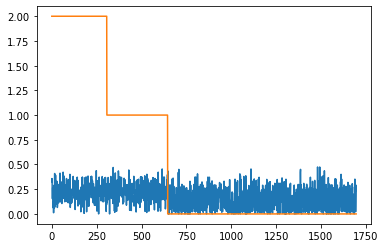

In [ ]:
similarities = np.array(df_relevances[df_relevances['topic'] == 5].sort_values(by=["judgement"],ascending=False).cosine_similarity)

import matplotlib.pyplot as plt
plt.plot(similarities)
plt.plot(np.array(df_relevances[df_relevances['topic'] == 5].sort_values(by=["judgement"],ascending=False).judgement))